In this script, we are going to calculate the free energy difference between states.
State 0 has a Hamiltonian $H_0=(x+2)^2$ in one-dimensional space, and state 1 has a Hamiltonian $H_1=(x-2)^2$.
These two Hamiltonians have the same shape, but shifted by 4 units along the axis.
Therefore, the free energy difference between these two states is zero, which can be seen from
\begin{equation}
\Delta A=-\ln\frac{\int\limits_{-\infty}^{\infty} e^{-H_1(x)}dx}{\int\limits_{-\infty}^{\infty} e^{-H_0(x)}dx}=-\ln\frac{\int\limits_{-\infty}^{\infty} e^{-(x-2)^2}dx}{\int\limits_{-\infty}^{\infty} e^{-(x+2)^2}dx}=-\ln\frac{\int\limits_{-\infty}^{\infty} e^{-(x-2)^2}dx}{\int\limits_{-\infty}^{\infty} e^{-(y-2)^2}dy}=-\ln 1=0
\end{equation}

We will use Thermodynamic Perturbation to calculate the free energy difference, which can be written as
\begin{eqnarray}
\Delta A=-\ln\frac{\int\limits_{-\infty}^{\infty} e^{-H_1(x)}dx}{\int\limits_{-\infty}^{\infty} e^{-H_0(x)}dx}=-\ln\frac{\int\limits_{-\infty}^{\infty} e^{-(H_1(x)-H_0(x))}e^{-H_0(x)}dx}{Z_0}=-\ln\left<e^{-\Delta H}\right>_0=-\ln\frac{1}{N_0}\sum\limits_{i=1}^{N_0}e^{-\Delta H_i}
\end{eqnarray}
We should also calculate the variance of $\Delta A$, which gives us the confidence of the number we obtain. The variance of quantity $x$ is defined as
$$\sigma^2_x=<x^2>-<x>^2.$$
The error propagation rule for variance is
$$\sigma^2_{f(x,y)}=\left(\frac{\partial f}{\partial x}\right)^2\sigma^2_x+\left(\frac{\partial f}{\partial y}\right)^2\sigma^2_y+2\frac{\partial f}{\partial x}\frac{\partial f}{\partial y}cov(x,y)$$
If we assume the samples are independent, the variance of the mean of $x$ equals to the variance of the sample divided by the number of samples, i.e.
$$\sigma^2_{<x>}=\frac{1}{N}\sigma^2_x.$$
Let's define $S=\frac{1}{N_0}\sum\limits_{i=1}^{N_0}e^{-\Delta H_i}$, then we have
$$\sigma^2_{\Delta A}=\frac{1}{S^2}\sigma^2_S$$

**Q: Where is the temperature?**

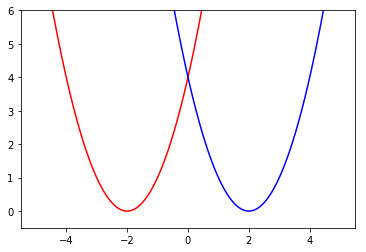

In [10]:
%matplotlib inline
from math import *
import numpy as np
import random
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
np.set_printoptions(precision=3)
def u0(x):
    return (x+2)**2
def u1(x):
    return (x-2)**2
x=np.linspace(-5,5,200)
y0=u0(x)
y1=u1(x)
plt.ylim(-.5, 6)
plt.plot(x,y0,'r',x,y1,'b')
plt.show()

In the first step, we will apply a direct TP calculation using the Equation shown above. 
Taking the explicit expressions for $H_0$ and $H_1$ in the equation above, we have
\begin{equation}
\Delta A=-\ln \left<e^{-\left[(x-2)^2-(x+2)^2\right]}\right>_0=-\ln\left<e^{8x}\right>_0
\end{equation}

Now we define a Monte Carlo (MC) propagator for this simulation. 
In the MC simulation, the transition between states must satisfy the detailed balance, i.e.
$$\rho(x_i)P(x_i,x_j)=\rho(x_j)P(x_j,x_i),$$
where $\rho(x_i)$ and $P(x_i,x_j)$ are the probability of the microstate $x_i$ and the transition probability from $x_i$ to $x_j$, 
respectively.
Suppose at $t_0$ the system is located at microstate $x_0$ with energy u(x_0). We make a random trial move to $x_1^t$ with energy 
$u(x_1^t)$.

if $u(x_1^t)<u(x_1^t)$

  {
  $x_1=x_1^t$
  }
  
else

  {
   generate a random number $s$ evenly distributed in [0,1]
  
   if $s<e^{-[u(x_1^t)-u(x_1^t)]}$
  
   {
    $x_1=x_1^t$
    }
    
   else
  
   {
    $x_1=x_0$
   }
  }

In [11]:
def MCpropagator(x0,dx,N,dN,u):
    count = 0
    x = np.empty(N)
    xcurrent = x0
    while count <N:
        innercount = 0
        while innercount < dN:
            rnd = np.random.uniform(0.0,1.0)
            if rnd < 0.5:
                xtrial = xcurrent - dx
            else:
                xtrial = xcurrent + dx

            deltau = u(xtrial) - u(xcurrent)
            if deltau < 0.0:
                xcurrent = xtrial
            else:
                acceptanceratio = np.exp(-deltau)
                if acceptanceratio > np.random.uniform(0.0,1.0):
                    xcurrent = xtrial
                else:
                    xcurrent = xcurrent
            innercount = innercount + 1
        x[count]=xcurrent
        count = count + 1
    return x, count

Number of samples generated:   10000
The distribution of the samples looks like:


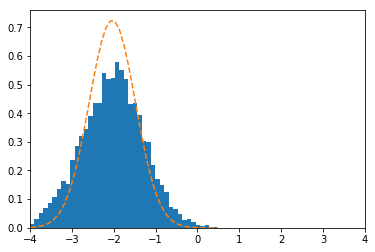

In [12]:
dx = 0.01
N = 10000
dN = 1600
x0 = -1.5
x = np.empty(N)
x, count = MCpropagator(x0,dx,N,dN,u0)
print('Number of samples generated:%8d' %count)
print('The distribution of the samples looks like:')
prob, bins, patches = plt.hist(x, bins=50, density=True)
mean = np.mean(x)
variance = np.var(x)
npdf = scipy.stats.norm.pdf(bins,mean,variance)
plt.plot(bins, npdf, '--')
plt.xlim(-4,4)
plt.show()

With these microstates sampled under $H_0$, we calculate the free energy difference.

In [13]:
def TP(x,u1,u0):
    edu = np.zeros(x.size)
    edu = np.exp(-(u1(x)-u0(x)))
    S = np.mean(edu)
    varS = np.var(edu)/x.size
    deltaA = -np.log(S)
    varA = varS/S**2
    return deltaA, varA

In [14]:
deltaA_direct, varA_direct = TP(x,u1,u0)
print('The free energy difference from a direct TP calculation is %8.2f +- %5.2f' % (deltaA_direct, sqrt(varA_direct)))

The free energy difference from a direct TP calculation is     3.67 +-  0.31


As you can see, the free energy differece from this direct TP calculation deviates from the true answer.
In the following, we will use another sampling method termed stratified sampling. In this method, we first introduce a series of intermediate states with a Hamiltonian $H_\lambda=\lambda H_1+(1-\lambda)H_0,\, \lambda \in (0,1)$. When $\lambda=0,\, H_\lambda=H_0$. And $H_\lambda=H_1$, when $\lambda=1$. The function for $H_\lambda$ is:

In [15]:
def ulmbd(lamb,x):
    return (1-lamb)*u0(x)+lamb*u1(x)

We can plot the potential energy surfaces


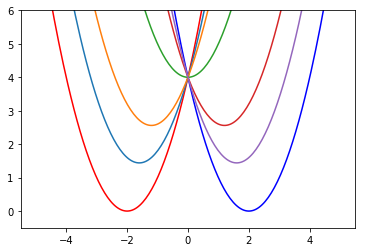

In [16]:
x=np.linspace(-5,5,200)
y0=ulmbd(0.0,x)
y1=ulmbd(0.1,x)
y2=ulmbd(0.2,x)
y5=ulmbd(0.5,x)
y8=ulmbd(0.8,x)
y9=ulmbd(0.9,x)
yN=ulmbd(1.0,x)
plt.ylim(-.5, 6)
plt.plot(x,y0,'r')
plt.plot(x,yN,'b')
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y5)
plt.plot(x,y8)
plt.plot(x,y9)
plt.show()

The free energy difference between $H_0$ and $H_1$ can be written as the sum of the free energy difference between each pair of neighboring states, i.e.
$$\Delta A_{0\rightarrow 1}=\sum\limits_{i=0}^{N-1}\Delta A_{\lambda_i\rightarrow \lambda_{i+1}}$$
We keep the total number of samples fixed and evenly distribute the samples to each simulation under $H_\lambda$.

In [17]:
def MCpropagator2(x0,dx,N,dN,ulmbd,lamb):
    count = 0
    x = np.empty(N)
    xcurrent = x0
    while count < N:
        innercount = 0
        while innercount < dN:
            rnd = np.random.uniform(0.,1.)
            if rnd<0.5:
                xtrial = xcurrent - dx
            else:
                xtrial = xcurrent + dx

            deltau = ulmbd(lamb,xtrial) - ulmbd(lamb,xcurrent)
            if deltau < 0:
                xcurrent = xtrial
            else:
                acceptanceratio = np.exp(-deltau)
                if acceptanceratio > np.random.uniform(0.0,1.0):
                    xcurrent = xtrial
                else:
                    xcurrent = xcurrent
            innercount = innercount + 1
        x[count] = xcurrent
        count = count + 1
    return x, count

def TP2(x,ulmbd,lmbd1,lmbd2):
    edu=np.zeros(x.size)
    edu = np.exp(-(ulmbd(lmbd2,x)-ulmbd(lmbd1,x)))
    S = np.mean(edu)
    varS = np.var(edu)/x.size
    deltaA = -np.log(S)
    varA = varS/S**2
    return deltaA, varA

The free energy difference from lambda 0 to lambda 1 is     1.47 +-  0.02
The free energy difference from lambda 1 to lambda 2 is     1.15 +-  0.02
The free energy difference from lambda 2 to lambda 3 is     0.77 +-  0.02
The free energy difference from lambda 3 to lambda 4 is     0.48 +-  0.02
The free energy difference from lambda 4 to lambda 5 is     0.15 +-  0.02
The free energy difference from lambda 5 to lambda 6 is    -0.19 +-  0.02
The free energy difference from lambda 6 to lambda 7 is    -0.54 +-  0.02
The free energy difference from lambda 7 to lambda 8 is    -0.77 +-  0.02
The free energy difference from lambda 8 to lambda 9 is    -1.02 +-  0.02
The free energy difference from lambda 9 to lambda 10 is    -1.47 +-  0.02

The total free energy difference is     0.03 +-  0.06


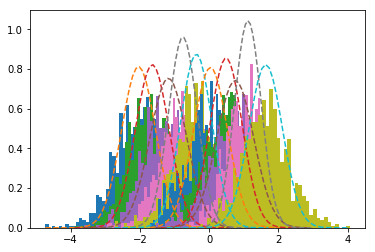

In [18]:
dx = 0.01
dlambda = 0.1
lambs = np.arange(0.0,1.,dlambda)
lambs = np.append(lambs,[1.0])
Ns = N//(len(lambs)-1)
deltaA = np.zeros(len(lambs)-1)
varA = np.zeros(len(lambs)-1)
i = 0
for i in range(len(lambs)-1):
    x0 = -1.5 + 3.0*i*dlambda
    x = np.empty(Ns)
    x, count = MCpropagator2(x0,dx,Ns,dN,ulmbd,lambs[i])
#    print('Number of samples generated:%8d for lambda= %5.2f' %(count,lambs[i]))
    prob, bins, patches = plt.hist(x, bins=50, density=True)
    mean = np.mean(x)
    variance = np.var(x)
    npdf = scipy.stats.norm.pdf(bins,mean,variance)
    plt.plot(bins, npdf, '--')
    deltaA[i], varA[i] = TP2(x,ulmbd,lambs[i],lambs[i+1])
    print('The free energy difference from lambda %d to lambda %d is %8.2f +- %5.2f' % (i,i+1,deltaA[i], sqrt(varA[i])))

print('')
print('The total free energy difference is %8.2f +- %5.2f' %(np.sum(deltaA),sqrt(np.sum(varA))))
plt.show()